# **Detecting and Mitigating Age Bias on Credit Decisions**

In [1]:
# Load all necessary packages
%pip install aif360
%matplotlib inline
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from common_utils import compute_metrics

all_metrics =  ["Statistical parity difference", "Average odds difference"]
german_dataset = GermanDataset(protected_attribute_names=['age'],
    privileged_classes=[lambda x: x >= 25], # age >=25 is considered privileged
    features_to_drop=['personal_status', 'sex'] # ignore sex-related attributes
)
german_dataset_train, german_dataset_test = german_dataset.split([0.7], shuffle=True)
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]
german_dataset_train, german_dataset_vt = german_dataset.split([0.7], shuffle=True)
german_dataset_valid, german_dataset_test = german_dataset_vt.split([0.5], shuffle=True)


Note: you may need to restart the kernel to use updated packages.


0.1.36ubuntu1 is an invalid version and will not be supported in a future release
0.23ubuntu1 is an invalid version and will not be supported in a future release
2022-05-13 15:58:18.708631: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-13 15:58:18.708656: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df=pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",sep=" ",header=None)
headers=["Status of existing checking account","Duration in month","Credit history",\
         "Purpose","Credit amount","Savings account/bonds","Present employment since",\
         "Installment rate in percentage of disposable income","Personal status and sex",\
         "Other debtors / guarantors","Present residence since","Property","Age in years",\
        "Other installment plans","Housing","Number of existing credits at this bank",\
        "Job","Number of people being liable to provide maintenance for","Telephone","foreign worker","Cost Matrix(Risk)"]
df.columns=headers
df.to_csv("german_data_credit_cat.csv",index=False) #save as csv file

#for structuring only
Status_of_existing_checking_account={'A14':"no checking account",'A11':"<0 DM", 'A12': "0 <= <200 DM",'A13':">= 200 DM "}
df["Status of existing checking account"]=df["Status of existing checking account"].map(Status_of_existing_checking_account)

Credit_history={"A34":"critical account","A33":"delay in paying off","A32":"existing credits paid back duly till now","A31":"all credits at this bank paid back duly","A30":"no credits taken"}
df["Credit history"]=df["Credit history"].map(Credit_history)

Purpose={"A40" : "car (new)", "A41" : "car (used)", "A42" : "furniture/equipment", "A43" :"radio/television" , "A44" : "domestic appliances", "A45" : "repairs", "A46" : "education", 'A47' : 'vacation','A48' : 'retraining','A49' : 'business','A410' : 'others'}
df["Purpose"]=df["Purpose"].map(Purpose)

Saving_account={"A65" : "no savings account","A61" :"<100 DM","A62" : "100 <= <500 DM","A63" :"500 <= < 1000 DM", "A64" :">= 1000 DM"}
df["Savings account/bonds"]=df["Savings account/bonds"].map(Saving_account)

Present_employment={'A75':">=7 years", 'A74':"4<= <7 years",  'A73':"1<= < 4 years", 'A72':"<1 years",'A71':"unemployed"}
df["Present employment since"]=df["Present employment since"].map(Present_employment)

Personal_status_and_sex={ 'A95':"female:single",'A94':"male:married/widowed",'A93':"male:single", 'A92':"female:divorced/separated/married", 'A91':"male:divorced/separated"}
df["Personal status and sex"]=df["Personal status and sex"].map(Personal_status_and_sex)


Other_debtors_guarantors={'A101':"none", 'A102':"co-applicant", 'A103':"guarantor"}
df["Other debtors / guarantors"]=df["Other debtors / guarantors"].map(Other_debtors_guarantors)


Property={'A121':"real estate", 'A122':"savings agreement/life insurance", 'A123':"car or other", 'A124':"unknown / no property"}
df["Property"]=df["Property"].map(Property)


Other_installment_plans={'A143':"none", 'A142':"store", 'A141':"bank"}
df["Other installment plans"]=df["Other installment plans"].map(Other_installment_plans)

Housing={'A153':"for free", 'A152':"own", 'A151':"rent"}
df["Housing"]=df["Housing"].map(Housing)

Job={'A174':"management/ highly qualified employee", 'A173':"skilled employee / official", 'A172':"unskilled - resident", 'A171':"unemployed/ unskilled  - non-resident"}
df["Job"]=df["Job"].map(Job)

Telephone={'A192':"yes", 'A191':"none"}
df["Telephone"]=df["Telephone"].map(Telephone)

foreign_worker={'A201':"yes", 'A202':"no"}
df["foreign worker"]=df["foreign worker"].map(foreign_worker)

risk={1:"Good Risk", 2:"Bad Risk"}
df["Cost Matrix(Risk)"]=df["Cost Matrix(Risk)"].map(risk)

display(Markdown("### Dataset rows"))
df.head()



### Dataset rows

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Cost Matrix(Risk)
0,<0 DM,6,critical account,radio/television,1169,no savings account,>=7 years,4,male:single,none,...,real estate,67,none,own,2,skilled employee / official,1,yes,yes,Good Risk
1,0 <= <200 DM,48,existing credits paid back duly till now,radio/television,5951,<100 DM,1<= < 4 years,2,female:divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,Bad Risk
2,no checking account,12,critical account,education,2096,<100 DM,4<= <7 years,2,male:single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,Good Risk
3,<0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,<100 DM,4<= <7 years,2,male:single,guarantor,...,savings agreement/life insurance,45,none,for free,1,skilled employee / official,2,none,yes,Good Risk
4,<0 DM,24,delay in paying off,car (new),4870,<100 DM,1<= < 4 years,3,male:single,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,Bad Risk


In [3]:
display(Markdown("### Dataset feature describe"))
df[["Credit amount","Age in years","Duration in month"]].describe()

### Dataset feature describe

,Credit amount,Age in years,Duration in month
count,1000.000000,1000.000000,1000.000000
mean,3271.258000,35.546000,20.903000
std,2822.736876,11.375469,12.058814
min,250.000000,19.000000,4.000000
25%,1365.500000,27.000000,12.000000
50%,2319.500000,33.000000,18.000000
75%,3972.250000,42.000000,24.000000
max,18424.000000,75.000000,72.000000


In [4]:
display(Markdown("### Dataset feature names"))
print(german_dataset_train.feature_names)

### Dataset feature names

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174', 'telephone=A191', 'telephone=A192', 'foreign_wor

# **Applying Logistic Regression on German original Dataset**

In [5]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(german_dataset_train.features)
y_train = german_dataset_train.labels.ravel()
w_train = german_dataset_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, sample_weight=german_dataset_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == german_dataset_train.favorable_label)[0][0]
german_dataset_train_pred = german_dataset_train.copy()
german_dataset_train_pred.labels = y_train_pred
german_dataset_valid_pred = german_dataset_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(german_dataset_valid_pred.features)
y_valid = german_dataset_valid_pred.labels
german_dataset_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
#Validating the orignal Dataset
german_dataset_test_pred = german_dataset_test.copy(deepcopy=True)
X_test = scale_orig.transform(german_dataset_test_pred.features)
y_test = german_dataset_test_pred.labels
german_dataset_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):

    fav_inds = german_dataset_valid_pred.scores > class_thresh
    german_dataset_valid_pred.labels[fav_inds] = german_dataset_valid_pred.favorable_label
    german_dataset_valid_pred.labels[~fav_inds] = german_dataset_valid_pred.unfavorable_label

    classified_metric_orig_valid = ClassificationMetric(german_dataset_valid,
                                             german_dataset_valid_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

# Calculating all the metrics for Orignal Dataset
display(Markdown("### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False

    fav_inds = german_dataset_test_pred.scores > thresh
    german_dataset_test_pred.labels[fav_inds] = german_dataset_test_pred.favorable_label
    german_dataset_test_pred.labels[~fav_inds] = german_dataset_test_pred.unfavorable_label

    metric_test_bef = compute_metrics(german_dataset_test, german_dataset_test_pred,
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

Best balanced accuracy (no reweighing) = 0.6994
Optimal classification threshold (no reweighing) = 0.6930


### Predictions from original testing data

Classification threshold used = 0.6930


 46%|████▌     | 46/100 [00:00<00:00, 458.17it/s]

Balanced accuracy = 0.7316
Statistical parity difference = -0.2296
Disparate impact = 0.6353
Average odds difference = -0.0342
Equal opportunity difference = 0.0474
Theil index = 0.2158


100%|██████████| 100/100 [00:00<00:00, 380.25it/s]


In [6]:

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6994
Optimal classification threshold (no reweighing) = 0.6930


# **Plotting all the metrics for Orignal dataset**

#### abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.However, for a classifier trained with original training data, at the best classification rate, this is high. This implies unfairness.

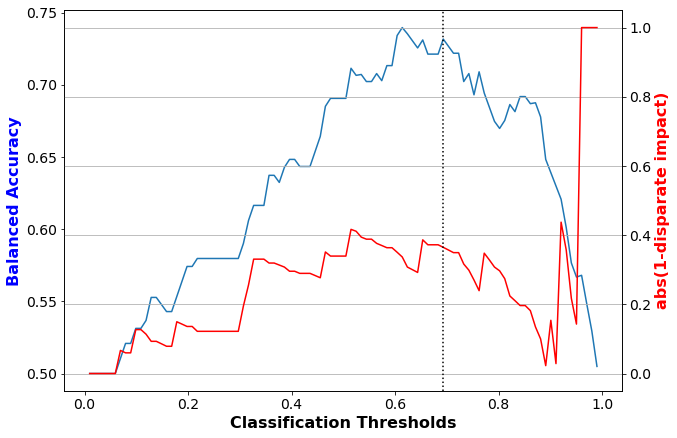

In [7]:
display(Markdown('#### abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.However, for a classifier trained with original training data, at the best classification rate, this is high. This implies unfairness.'))
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

#### Average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

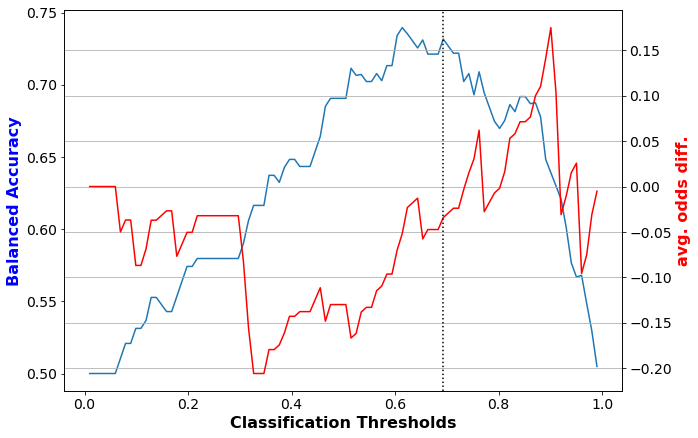

In [8]:
display(Markdown('#### Average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.'))
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

# **Detection of Biasness**

In [9]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(german_dataset_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("## Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

## Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.116580


# **Mitigation of Biasness**

In [10]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(german_dataset_train)
dataset_transf_train = RW.transform(german_dataset_train)

In [11]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("## Mitigation of Biasness to Transformed training dataset using Reweighing in ai360"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

## Mitigation of Biasness to Transformed training dataset using Reweighing in ai360

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


# **Applying Logistics Regresssion on Transformed Data(Bias Mitigated Dataset)**

In [12]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [13]:
dataset_transf_test_pred = german_dataset_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

# **Calculate all the metrics for Transformed Data**

In [14]:
display(Markdown("### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(german_dataset_test, dataset_transf_test_pred,
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

### Predictions from transformed testing data

Classification threshold used = 0.6930


100%|██████████| 100/100 [00:00<00:00, 603.18it/s]

Balanced accuracy = 0.7108
Statistical parity difference = -0.1704
Disparate impact = 0.7326
Average odds difference = 0.0027
Equal opportunity difference = 0.0474
Theil index = 0.2192


# **Plot all the metrics for transformed data**

#### abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness

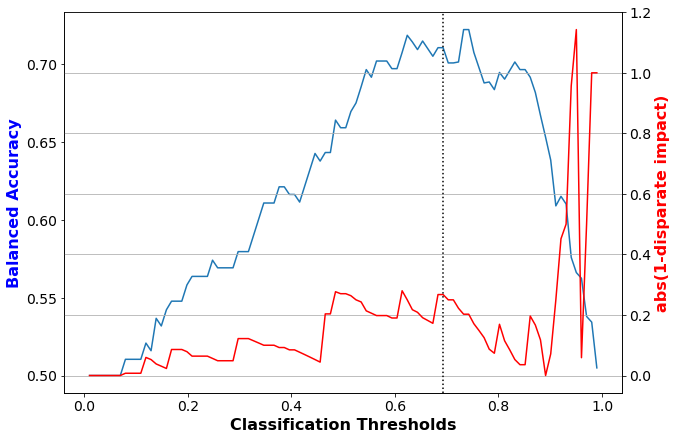

In [15]:
display(Markdown("#### abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness"))
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)


#### Average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair. For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness.

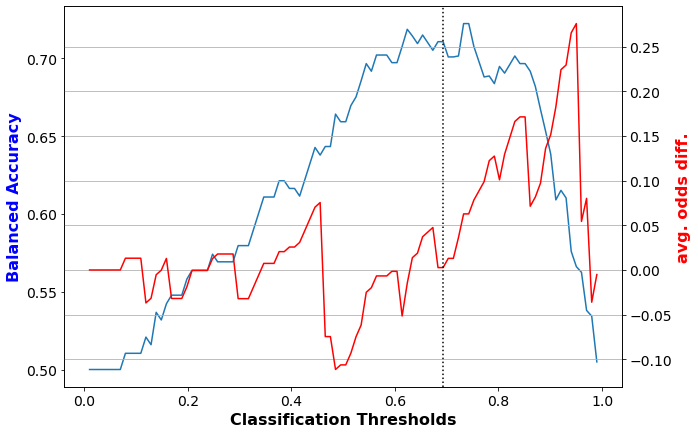

In [16]:
display(Markdown("#### Average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair. For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness."))

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)